## Personalized Cancer Diagnosis

**Featurization:** Word2Vec

**Data Source:**https://www.kaggle.com/c/msk-redefining-cancer-treatment

In [2]:
#Importing all necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Reading Gene,Variation and Text Data

In [3]:
#Loading training_text.csv file.
data_text = pd.read_csv('training_text',sep='\|\|',header=None,skiprows=1,names=['ID','Text'],engine='python')
print("Number Data Points: ",data_text.shape[0])
print("Number Features: ",data_text.shape[1])
data_text.head()

Number Data Points:  3321
Number Features:  2


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


**Text:** Clinical Literature data written by professional doctors.

In [4]:
#Loading training_variants.csv file.
data_var = pd.read_csv('training_variants')
print("Number of Data points: ",data_var.shape[0])
print("Number of Features: ",data_var.shape[1])
data_var.head()

Number of Data points:  3321
Number of Features:  4


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


**ID:** the id of the row used to link the mutation to the clinical evidence

**Gene:** the gene where this genetic mutation is located

**Variation:** the aminoacid change for this mutations.

**Class:** 1-9 the class this genetic mutation has been classified on

In [5]:
#Now joining train_var_df and train_text_df using merge function.
data = pd.merge(data_var, data_text, how='left', on='ID')
data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


#### Combining Words with '_'

In [6]:
data.Gene = data.Gene.str.replace('\s+','_')
data.Variation = data.Variation.str.replace('\s+','_')
data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating_Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


#### Data Split: Train,CV and Test

In [7]:
from sklearn.model_selection import train_test_split
y_true = data['Class'].values
#Split the data as train and test 
X_1, X_test, y_1, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)
#Split the X_1 and y_1 into train and Cross validate
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, stratify=y_1, test_size=0.2)
print(type(y_cv))
print(type(y_test))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
print("Number of data points in Train data:",X_train.shape[0])
print("Number of data points in Cross validation data:",X_cv.shape[0])
print("Number of data points in Test data:",X_test.shape[0])

Number of data points in Train data: 2124
Number of data points in Cross validation data: 532
Number of data points in Test data: 665


### Univariate Analysis

In [9]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['X_train', 'X_test', 'X_cv']
# algorithm
# -----------------------------------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = X_train[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = X_train.loc[(X_train['Class']==k) & (X_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = X_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

**How to Featurize this Gene feature?**
* One hot encoding.

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
#One hot encoding of the gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])

In [11]:
#Lets cross check the shape of the data frame
print("The shape of the train_gene_feature_onehotCoding", train_gene_feature_onehotCoding.shape)
print("The shape of the cv_gene_feature_tfidfVectorizer", cv_gene_feature_onehotCoding.shape)
print("The shape of the test_gene_feature_tfidfVectorizer", test_gene_feature_onehotCoding.shape)

The shape of the train_gene_feature_onehotCoding (2124, 237)
The shape of the cv_gene_feature_tfidfVectorizer (532, 237)
The shape of the test_gene_feature_tfidfVectorizer (665, 237)


In [12]:
print(type(train_gene_feature_onehotCoding))
print(type(cv_gene_feature_onehotCoding))
print(type(test_gene_feature_onehotCoding))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


**How to featurize the Variation Feature?**
* One hot Encoding.

We will use both of the methods to featurize variation feature.

In [13]:
# One-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])

In [14]:
print("The shape of train_variation_feature_onehotCoding is",train_variation_feature_onehotCoding.shape)
print("The shape of cv_variation_feature_onehotCoding is",cv_variation_feature_onehotCoding.shape)
print("The shape of test_variation_feature_onehotCoding is",test_variation_feature_onehotCoding.shape)

The shape of train_variation_feature_onehotCoding is (2124, 1936)
The shape of cv_variation_feature_onehotCoding is (532, 1936)
The shape of test_variation_feature_onehotCoding is (665, 1936)


In [15]:
print(type(train_variation_feature_onehotCoding))
print(type(cv_variation_feature_onehotCoding))
print(type(test_variation_feature_onehotCoding))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


**How to featurize the Text data?**

* Avg Word2Vec

In [16]:
import re
def cleanhtml(sentence): #function to clean the word of any html tags.
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence): #Function to clean words of punctuation.
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|(|)|\|/]',r'',cleaned)
    return cleaned

#### Train Text data

In [17]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#Train your own Word2Vec Model using our own text Corpus
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
i=0
train_list_of_sent=[]
for sent in X_train['Text'].values:
    train_filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if (cleaned_words.isalpha()):
                train_filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    train_list_of_sent.append(train_filtered_sentence)

In [18]:
print(X_train['Text'].values[0])
print("-------------------------------------------------------------------------------------------------------------------")
print(train_list_of_sent[0])

Background: IGF-I receptor (IGF1R) plays an essential role in human intrauterine and postnatal development. Few heterozygous mutations in IGF1R leading to IGF-I resistance and intrauterine and postnatal growth retardation have been described to date. Objective: The clinical and functional relevance of a novel heterozygous IGF1R mutation identified in a girl with short stature and six relatives was evaluated. Patients: Affected individuals showed birth lengths between âˆ’1.40 and âˆ’1.82 SD score (SDS) and birth weights between âˆ’1.84 and âˆ’2.19 SDS. Postnatal growth retardation ranged between âˆ’1.51 and âˆ’3.93 height SDS. Additional phenotypic findings were variable including microcephaly, clinodactyly, delayed menarche, and diabetes mellitus type 2. Genetic analyses were initiated due to elevated IGF-I levels of the girl. Results: Denaturing HPLC screening and direct DNA sequencing revealed a heterozygous G3464C IGF1R mutation in exon 19 located within a phylogenetically conserved

In [19]:
train_w2v_model = Word2Vec(train_list_of_sent, min_count=5, size=300, workers=4)

In [20]:
train_words = list(train_w2v_model.wv.vocab)
print(len(train_words))

27132


In [21]:
#get a Numerical Vector for a given Word.
train_w2v_model.wv['mutation']

array([ 0.20868532,  0.35092035,  0.10309987, -1.2783242 , -1.7600317 ,
        0.6983618 , -0.3034544 ,  0.6567861 , -1.3236614 ,  0.34037387,
       -0.8343478 , -1.4124455 , -0.01950884, -2.0061579 ,  0.25242293,
       -1.0470796 , -0.362597  , -0.4154935 ,  3.400504  ,  0.44173107,
       -2.4562335 ,  0.8036477 , -1.635158  ,  0.11438094,  0.41314018,
        1.4511566 , -1.690768  ,  0.951361  , -0.9947905 ,  0.9162036 ,
        0.99852264,  1.6029277 ,  2.070208  ,  1.7065834 , -0.7768532 ,
       -1.5770801 ,  1.7997017 ,  0.07004072,  0.991229  , -1.37361   ,
        0.34713978,  1.0894698 ,  0.35426575,  0.3836888 ,  0.6115347 ,
        1.0326014 ,  0.8031506 ,  0.51512045,  2.6967702 , -1.5353885 ,
       -0.08535004,  0.7773916 , -0.8255371 ,  0.0654287 ,  1.9011261 ,
        0.36022615, -0.41507602,  2.066177  , -1.3775198 ,  0.9011408 ,
        1.7790805 ,  0.9073174 ,  0.43329856,  1.6475971 , -1.0475843 ,
       -0.08739655, -0.12148545,  0.7776414 , -0.72493905,  0.24

In [22]:
#Average Word2Vec
#Compute average w2v for each document
train_sent_vectors = []; 
for sent in train_list_of_sent:
    sent_vec = np.zeros(300)
    cnt_words = 0;
    for word in sent:
        try:
            vec = train_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))
#print(sent_vectors[:5])

2124
300


In [23]:
type(train_sent_vectors)

list

#### CV Text Data

In [24]:
#Cross Validation data set's text feature.
#Train your own Word2Vec Model using our own text Corpus
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
i=0
cv_list_of_sent=[]
for sent in X_cv['Text'].values:
    cv_filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if (cleaned_words.isalpha()):
                cv_filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    cv_list_of_sent.append(cv_filtered_sentence)

In [25]:
print(X_cv['Text'].values[0])
print("-------------------------------------------------------------------------------------------------------------------")
print(cv_list_of_sent[0])

Inherited mutations affecting the INK4a/ARF locus (CDKN2A) are associated with melanoma susceptibility in 40% of multiple case melanoma families. Over 60 different germline INK4a/ARF mutations have been detected in more than 190 families worldwide. The majority of these alterations are missense mutations affecting p16INK4a, and only 25% of these have been functionally assessed. There is therefore a need for an accurate and rapid assay to determine the functional significance of p16INK4a mutations. We reviewed the performance of several in vivo functional assays that measure critical aspects of p16INK4a function, including subcellular location, CDK binding and cell cycle inhibition. In this report the function of 28 p16INK4a variants, many associated with melanoma susceptibility were compared. We show that assessment of CDK4 binding and subcellular localization can accurately and rapidly determine the functional significance of melanomaassociated p16INK4a mutations. p16INK4a-CDK6 bindin

In [26]:
cv_w2v_model = Word2Vec(cv_list_of_sent, min_count=5, size=300, workers=4)

In [27]:
cv_words = list(cv_w2v_model.wv.vocab)
print(len(cv_words))

14238


In [28]:
#get a Numerical Vector for a given Word.
cv_w2v_model.wv['mutation']

array([ 0.22004537, -0.44285658, -0.6454962 , -0.13516328, -1.4091213 ,
        0.29510272, -0.77405643,  3.1484025 ,  0.12642749,  0.0959128 ,
       -0.7749278 ,  0.6420613 , -0.56125087, -1.1633793 , -1.0645756 ,
       -0.9028753 ,  1.369791  , -1.7231613 , -0.9066202 ,  0.01528725,
       -0.23744464,  1.4693953 , -0.6421929 ,  0.692299  ,  1.4781191 ,
       -1.0963485 , -0.2358279 , -0.664646  , -1.5474088 , -0.7666627 ,
       -0.7896216 , -0.6160272 ,  1.0240399 ,  1.6077607 ,  0.63371253,
        0.6303355 , -0.37178665, -0.68397117,  0.6397318 , -2.3676865 ,
       -1.2502371 , -0.5139945 ,  1.1731844 , -0.08532533,  0.12101722,
        0.84991974,  0.86502767,  0.52526873,  0.3069148 ,  0.47385114,
        0.6198113 ,  2.735106  ,  0.3070061 , -0.08417095,  0.8981861 ,
        0.40795207,  0.81935483,  0.42819688,  0.6145948 ,  0.10420647,
        1.5754294 , -0.35384554,  0.89132786,  0.4110913 ,  0.99784535,
       -1.1929889 , -0.6305685 ,  0.55441064,  0.71583843, -0.14

In [29]:
#Average Word2Vec
#Compute average w2v for each document
cv_sent_vectors = []; 
for sent in cv_list_of_sent:
    sent_vec = np.zeros(300)
    cnt_words = 0;
    for word in sent:
        try:
            vec = cv_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    cv_sent_vectors.append(sent_vec)
print(len(cv_sent_vectors))
print(len(cv_sent_vectors[0]))
#print(cv_sent_vectors[:5])

532
300


In [30]:
type(cv_sent_vectors)

list

#### Test Text Data

In [31]:
#Test data set's Text feature.
#Train your own Word2Vec Model using our own text Corpus
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
i=0
test_list_of_sent=[]
for sent in X_test['Text'].values:
    test_filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if (cleaned_words.isalpha()):
                test_filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    test_list_of_sent.append(test_filtered_sentence)

In [32]:
print(X_test['Text'].values[0])
print("-------------------------------------------------------------------------------------------------------------------")
print(test_list_of_sent[0])

Introduction Hypochondroplasia (MIM 146000) is an autosomal dominant skeletal dysplasia that was probably first described by Ravenna (1913) but not generally recognized until much later, the term being coined by Maroteaux and Lamy (1960). Although many reports characterizing the phenotypic features have since appeared in the literature (Kozlowski 1965; Beals 1969; Walker et al. 1971; Hall and Spranger 1979; Wynne-Davies et al. 1981; Maroteaux and Falzon 1988), it is sometimes difficult to make a definitive diagnosis of hypochondroplasia solely on the basis of physical and radiological findings, especially in young children and milder cases. Hypochondroplasia and achondroplasia share many phenotypic features (e.g., apparent rhizomelia, limitation of elbow extension, tibial bowing, exaggerated lumbar lordosis, metaphyseal flaring, shortening of the pedicles, narrowing of the lumbar interpediculate distance, squared ilia, shortened femoral necks, brachydactyly, macrocephaly, and distincti

In [33]:
test_w2v_model = Word2Vec(test_list_of_sent, min_count=5, size=300, workers=4)

In [34]:
test_words = list(test_w2v_model.wv.vocab)
print(len(test_words))

16112


In [35]:
#get a Numerical Vector for a given Word.
test_w2v_model.wv['mutation']

array([ 5.63934565e-01, -7.48723924e-01,  1.71128318e-01,  6.51822448e-01,
       -6.00209475e-01,  8.95265520e-01, -4.06188965e-01,  3.08621192e+00,
       -1.03206718e+00,  7.61500955e-01,  4.83835667e-01,  2.14645430e-01,
       -2.52770722e-01, -2.53545165e+00, -1.15212536e+00, -1.31820464e+00,
        9.06662226e-01, -3.05563539e-01, -9.86405730e-01,  2.72650924e-02,
       -2.05538079e-01,  1.71072924e+00,  4.43561107e-01,  5.84568799e-01,
       -2.03070149e-01, -9.38108861e-01, -8.40138972e-01,  8.13250721e-01,
       -1.12793458e+00, -1.02239203e+00, -6.88301504e-01,  1.01502395e+00,
        1.03295648e+00,  2.32737374e+00,  2.48331159e-01, -1.22752190e+00,
        3.02929431e-01, -1.52301323e+00,  1.06461191e+00, -2.06002378e+00,
        1.14776409e+00, -1.44505784e-01, -6.64109141e-02, -3.25280756e-01,
       -9.73284304e-01,  1.25998223e+00, -5.15216351e-01, -4.74155426e-01,
        1.96984160e+00, -5.75247526e-01,  6.72172666e-01,  8.01836252e-01,
        1.18240082e+00, -

In [38]:
#Average Word2Vec
#Compute average w2v for each document
test_sent_vectors = []; 
for sent in test_list_of_sent:
    sent_vec = np.zeros(300)
    cnt_words = 0;
    for word in sent:
        try:
            vec = test_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))
#print(test_sent_vectors[:5])

665
300


In [39]:
type(test_sent_vectors)

list

#### How does Text feature helping in predicting yi's?

For values of alpha =  1e-05 The log loss is: 2.652428028648379
For values of alpha =  0.0001 The log loss is: 2.6632026605241013
For values of alpha =  0.001 The log loss is: 3.218951784533249
For values of alpha =  0.01 The log loss is: 2.5437666778483647
For values of alpha =  0.1 The log loss is: 2.0124430015525516
For values of alpha =  1 The log loss is: 2.0297258541014034


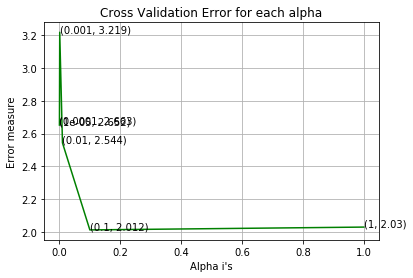

For values of best alpha =  0.1 The train log loss is: 1.4635650718798274
For values of best alpha =  0.1 The cross validation log loss is: 2.0124430015525516
For values of best alpha =  0.1 The test log loss is: 1.9666566907084857


In [40]:
# Train a Logistic regression+Calibration model using text features whicha re tfidf vectorizer
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_sent_vectors, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_sent_vectors, y_train)
    predict_y = sig_clf.predict_proba(cv_sent_vectors)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_sent_vectors, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_sent_vectors, y_train)

predict_y = sig_clf.predict_proba(train_sent_vectors)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_sent_vectors)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_sent_vectors)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Machine Learning Models

In [41]:
#Data preparation for ML models.
#Misc. functionns for ML models
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [42]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [43]:
# This function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [44]:
from scipy.sparse import hstack
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

#Word2Vec
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_word2vec = hstack((train_gene_var_onehotCoding, train_sent_vectors)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_word2vec = hstack((test_gene_var_onehotCoding, test_sent_vectors)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_word2vec = hstack((cv_gene_var_onehotCoding, cv_sent_vectors)).tocsr()
cv_y = np.array(list(X_cv['Class']))


### BaseLine Models

### Naive Bayes

#### Hyperparameter Tuning:

In [61]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_word2vec, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_word2vec, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_word2vec, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_word2vec, y_train)


predict_y = sig_clf.predict_proba(train_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 1e-05


ValueError: Input X must be non-negative

#### Testing Model with best HyperParameter

Log Loss : 1.2887621940826983
Number of missclassified point : 0.40601503759398494
-------------------------------------------------- Confusion Matrix --------------------------------------------------


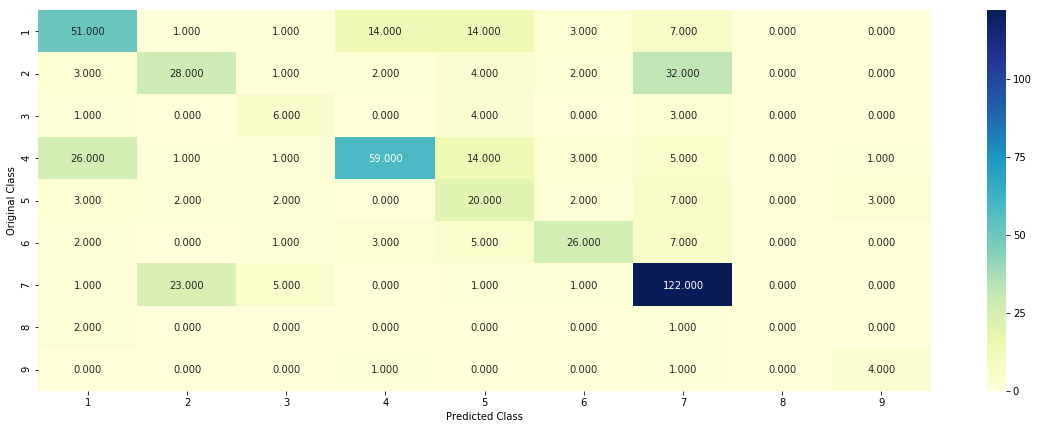

--------------------------------------------- Recall Matrix (Row Sum=1) ---------------------------------------------


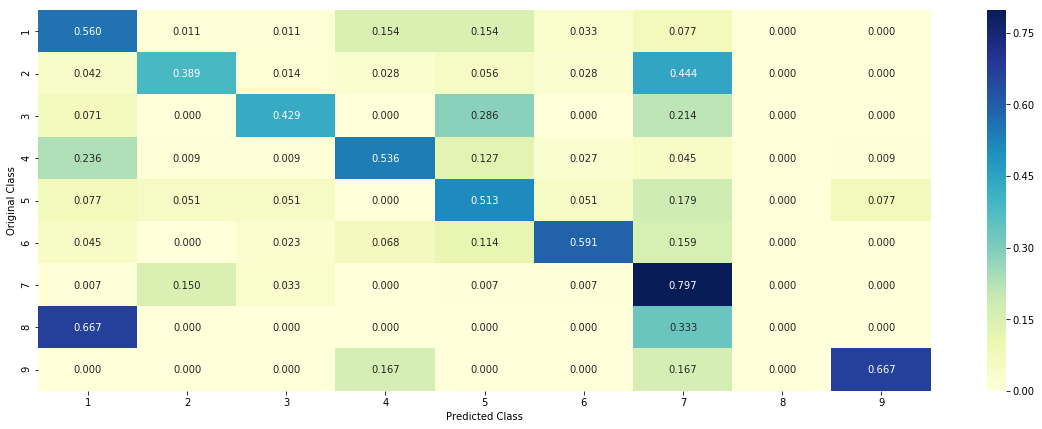

--------------------------------------------- Precision Matrix (Column Sum=1) ---------------------------------------------


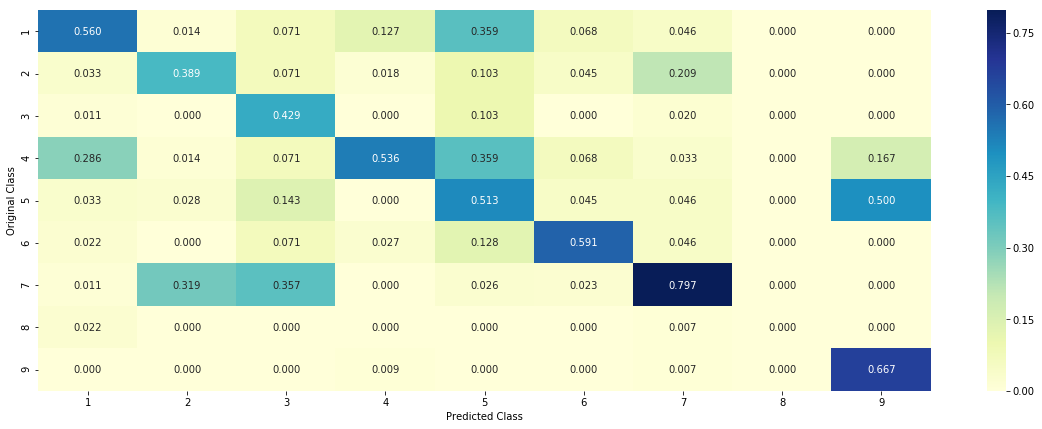

In [54]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X

# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### Feature Importance, Correctly Classified Point

In [55]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0935 0.0737 0.0103 0.1106 0.0364 0.0377 0.6273 0.0048 0.0058]]
Actual Class : 7
--------------------------------------------------
16 Text feature [kinase] present in test data point [True]
17 Text feature [presence] present in test data point [True]
18 Text feature [activating] present in test data point [True]
19 Text feature [contrast] present in test data point [True]
20 Text feature [inhibitor] present in test data point [True]
21 Text feature [downstream] present in test data point [True]
22 Text feature [potential] present in test data point [True]
23 Text feature [cells] present in test data point [True]
24 Text feature [recently] present in test data point [True]
25 Text feature [expressing] present in test data point [True]
26 Text feature [independent] present in test data point [True]
27 Text feature [showed] present in test data point [True]
28 Text feature [well] present in test data point [True]
29 Text feature [prev

#### Feature Importance, Correctly Classified point

In [58]:
test_point_index = 130
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.094  0.256  0.0103 0.1113 0.0366 0.0379 0.4432 0.0048 0.0059]]
Actual Class : 2
--------------------------------------------------
16 Text feature [kinase] present in test data point [True]
17 Text feature [presence] present in test data point [True]
18 Text feature [activating] present in test data point [True]
19 Text feature [contrast] present in test data point [True]
20 Text feature [inhibitor] present in test data point [True]
21 Text feature [downstream] present in test data point [True]
22 Text feature [potential] present in test data point [True]
23 Text feature [cells] present in test data point [True]
24 Text feature [recently] present in test data point [True]
25 Text feature [expressing] present in test data point [True]
26 Text feature [independent] present in test data point [True]
27 Text feature [showed] present in test data point [True]
28 Text feature [well] present in test data point [True]
29 Text feature [prev

### K-Nearest Neighbour Classifier

#### HyperParameter Tuning

for alpha = 5
Log Loss : 1.6758269152609924
for alpha = 11
Log Loss : 1.6440130469142515
for alpha = 15
Log Loss : 1.6340053004902444
for alpha = 21
Log Loss : 1.6587165537886974
for alpha = 31
Log Loss : 1.6668329775104431
for alpha = 41
Log Loss : 1.672403688827378
for alpha = 51
Log Loss : 1.6964796040089667
for alpha = 99
Log Loss : 1.619141010507675


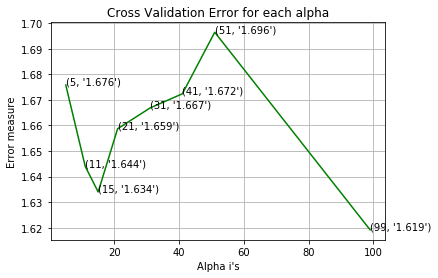

For values of best alpha =  99 The train log loss is: 1.3099502510938266
For values of best alpha =  99 The cross validation log loss is: 1.619141010507675
For values of best alpha =  99 The test log loss is: 1.5847687724320891


In [49]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ---------------------------------------------------------------------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification.
#-------------------------------------------------------------------------------
from sklearn.neighbors import KNeighborsClassifier
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_word2vec, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_word2vec, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_word2vec)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_word2vec, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_word2vec, y_train)

predict_y = sig_clf.predict_proba(train_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### Testing the Model with best hyperparameter

Log loss : 1.0212524461383197
Number of mis-classified points : 0.34774436090225563
-------------------------------------------------- Confusion Matrix --------------------------------------------------


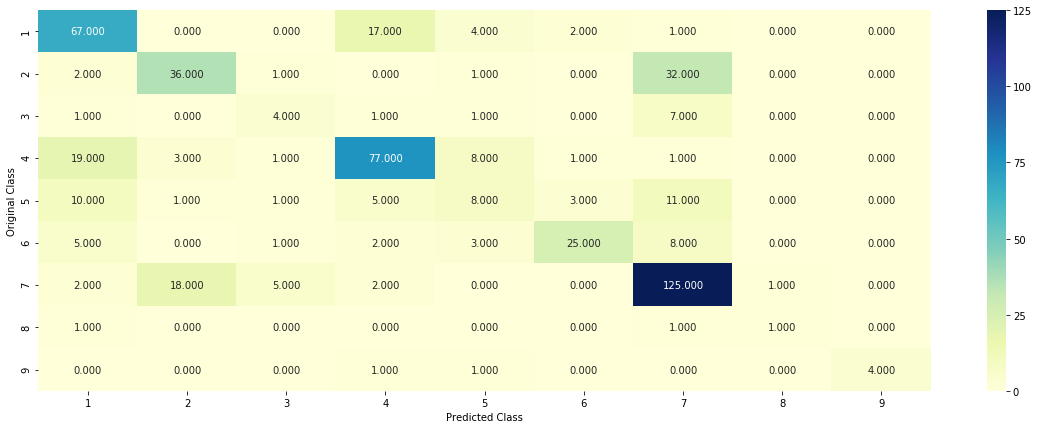

--------------------------------------------- Recall Matrix (Row Sum=1) ---------------------------------------------


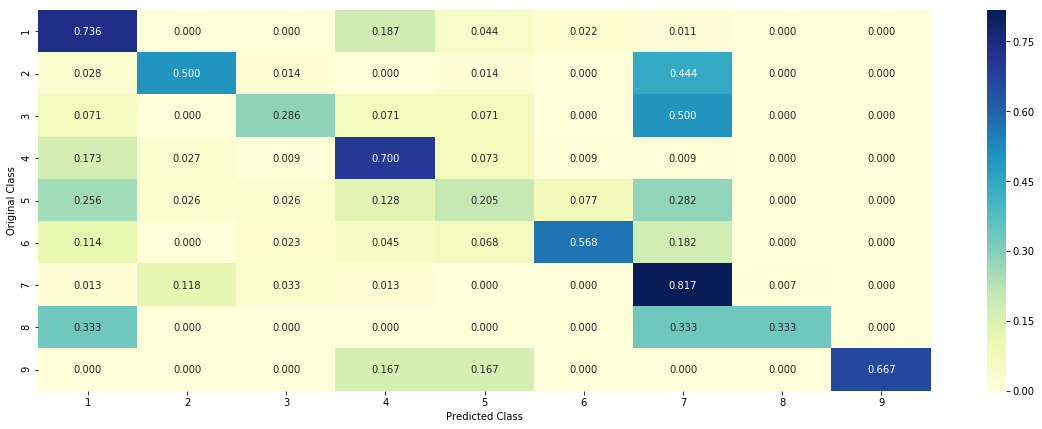

--------------------------------------------- Precision Matrix (Column Sum=1) ---------------------------------------------


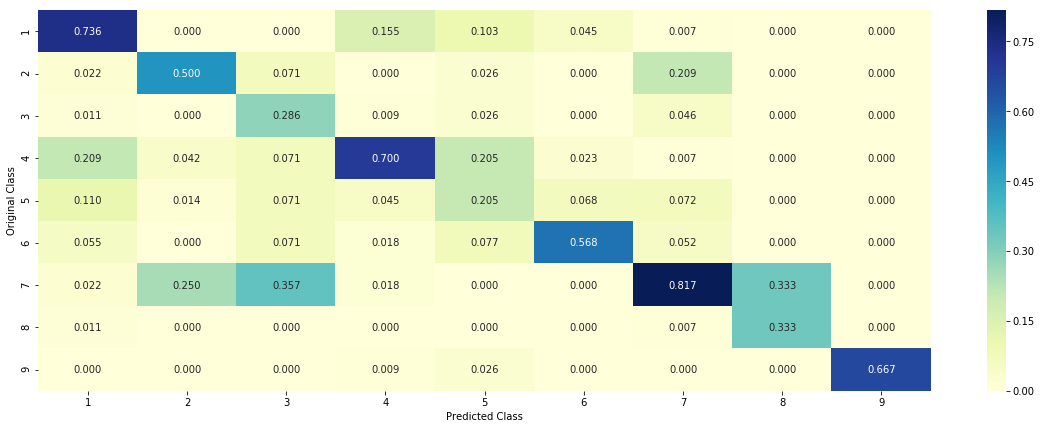

In [60]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#---------------------------------------------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

#### Sample Query Point-1

In [61]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  5  nearest neighbours of the test points belongs to classes [4 2 4 1 2]
Fequency of nearest points : Counter({4: 2, 2: 2, 1: 1})


#### Sample Query Point-2

In [64]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 1
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [4 4 1 2 4]
Fequency of nearest points : Counter({4: 3, 1: 1, 2: 1})


### Logistic Regression(With Class balancing)

#### HyperParameter Tuning

for alpha = 1e-06
Log Loss : 1.6601649089199113
for alpha = 1e-05
Log Loss : 1.6634291685036084
for alpha = 0.0001
Log Loss : 1.7360111092072261
for alpha = 0.001
Log Loss : 1.6917273772537087
for alpha = 0.01
Log Loss : 1.8640914743036199
for alpha = 0.1
Log Loss : 2.0146556335708086
for alpha = 1
Log Loss : 2.041678568055908
for alpha = 10
Log Loss : 2.114643010571609
for alpha = 100
Log Loss : 2.1217551064914812


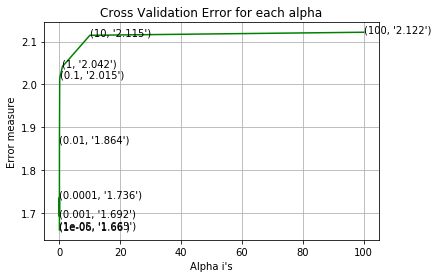

For values of best alpha =  1e-06 The train log loss is: 0.809532579218405
For values of best alpha =  1e-06 The cross validation log loss is: 1.6601649089199113
For values of best alpha =  1e-06 The test log loss is: 1.6725833258340117


In [52]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# -------------------------------------------------------------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------------------------------------------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#---------------------------------------------------------------------------------------------

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_word2vec, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_word2vec, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_word2vec)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_word2vec, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_word2vec, y_train)

predict_y = sig_clf.predict_proba(train_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Testing the Model with best hyperParameter

Log loss : 1.2509418082237151
Number of mis-classified points : 0.35714285714285715
-------------------------------------------------- Confusion Matrix --------------------------------------------------


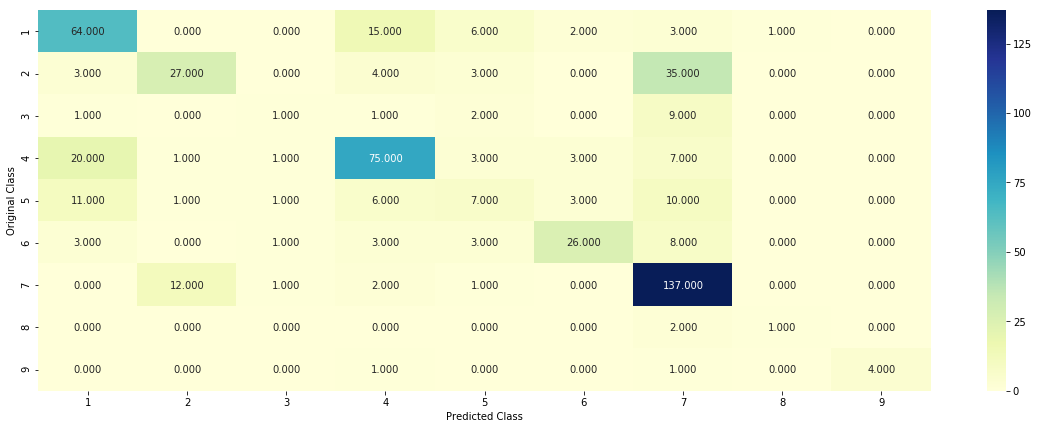

--------------------------------------------- Recall Matrix (Row Sum=1) ---------------------------------------------


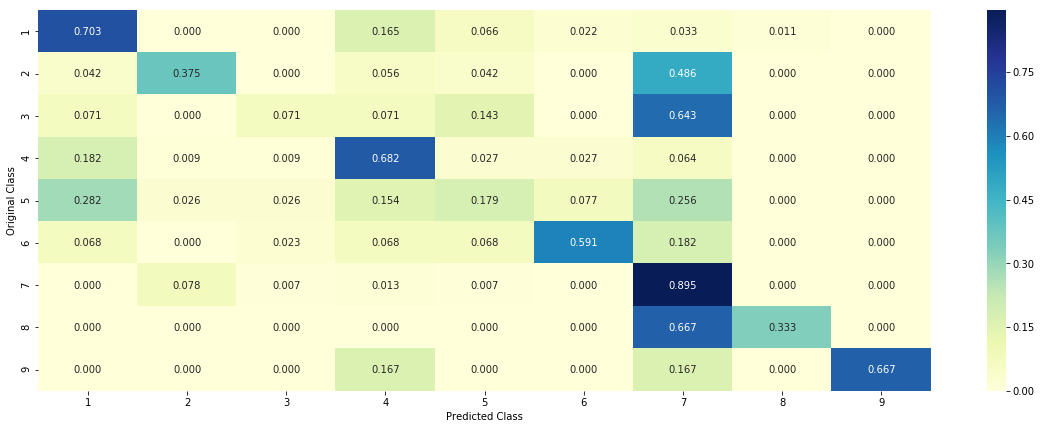

--------------------------------------------- Precision Matrix (Column Sum=1) ---------------------------------------------


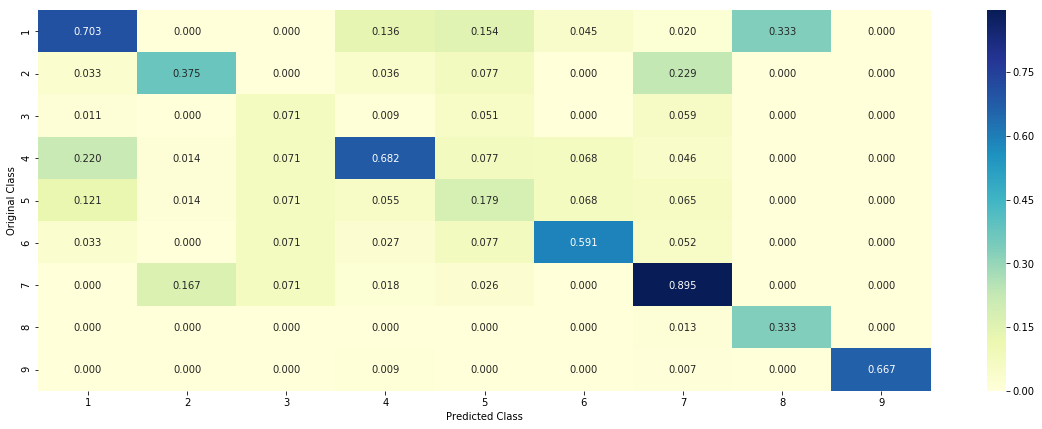

In [66]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)
# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Feature Importance

In [67]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

#### Incorrectly Classified Point

In [71]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.3312 0.0711 0.0173 0.3947 0.0303 0.0187 0.1141 0.01   0.0126]]
Actual Class : 1
--------------------------------------------------
110 Text feature [degrade] present in test data point [True]
169 Text feature [g245d] present in test data point [True]
172 Text feature [suppressor] present in test data point [True]
385 Text feature [degradation] present in test data point [True]
Out of the top  500  features  4 are present in query point


#### Correctly Classified Point

In [72]:
test_point_index = 500
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0465 0.0252 0.0134 0.5804 0.0268 0.019  0.2762 0.005  0.0075]]
Actual Class : 4
--------------------------------------------------
280 Text feature [disease3] present in test data point [True]
385 Text feature [degradation] present in test data point [True]
Out of the top  500  features  2 are present in query point


### Logistic Regression(Without Class balancing) 

#### HyperParameter Tuning

for alpha = 1e-06
Log Loss : 1.7515641571045268
for alpha = 1e-05
Log Loss : 1.985364880089731
for alpha = 0.0001
Log Loss : 1.8570228975366962
for alpha = 0.001
Log Loss : 2.058211122881814
for alpha = 0.01
Log Loss : 2.0986901868341015
for alpha = 0.1
Log Loss : 2.001256904526711
for alpha = 1
Log Loss : 2.0191209881667267


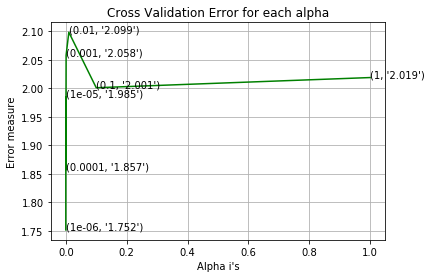

For values of best alpha =  1e-06 The train log loss is: 0.8046286360632181
For values of best alpha =  1e-06 The cross validation log loss is: 1.7515641571045268
For values of best alpha =  1e-06 The test log loss is: 1.7308725191735623


In [53]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_word2vec, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_word2vec, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_word2vec)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_word2vec, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_word2vec, y_train)

predict_y = sig_clf.predict_proba(train_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Testing Model with best HyperParameter

Log loss : 1.2644315889348279
Number of mis-classified points : 0.35150375939849626
-------------------------------------------------- Confusion Matrix --------------------------------------------------


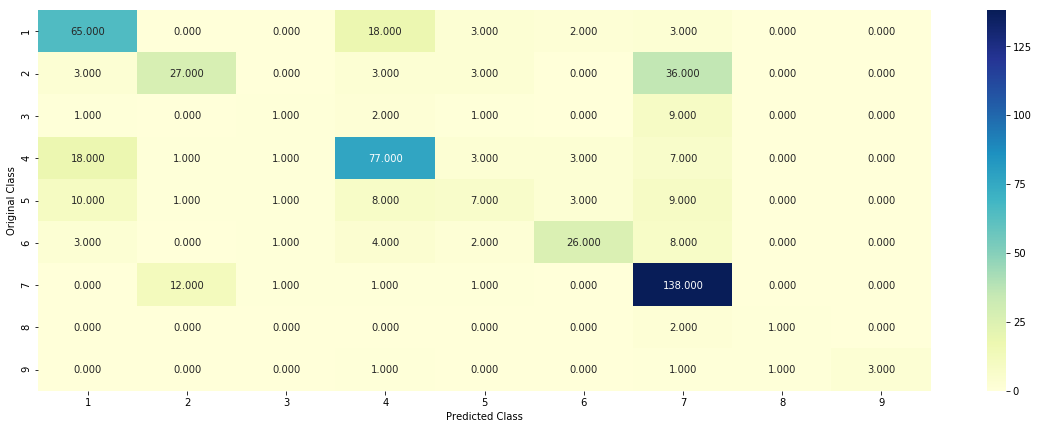

--------------------------------------------- Recall Matrix (Row Sum=1) ---------------------------------------------


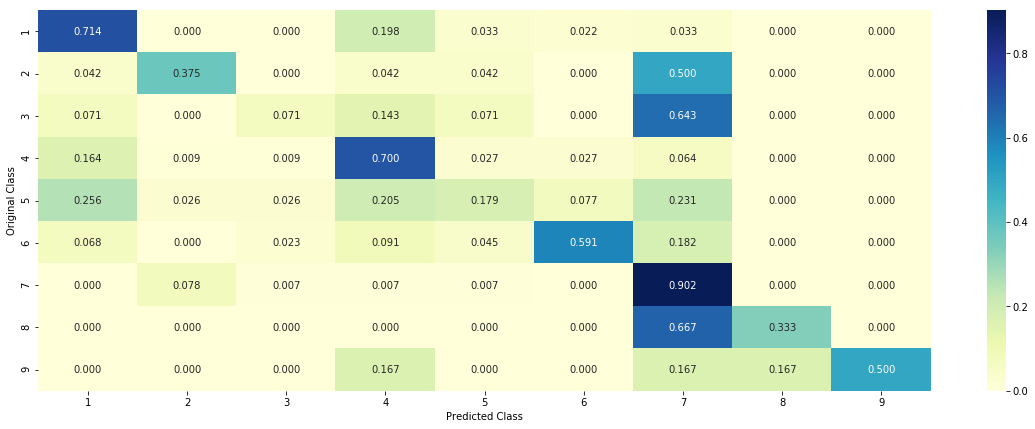

--------------------------------------------- Precision Matrix (Column Sum=1) ---------------------------------------------


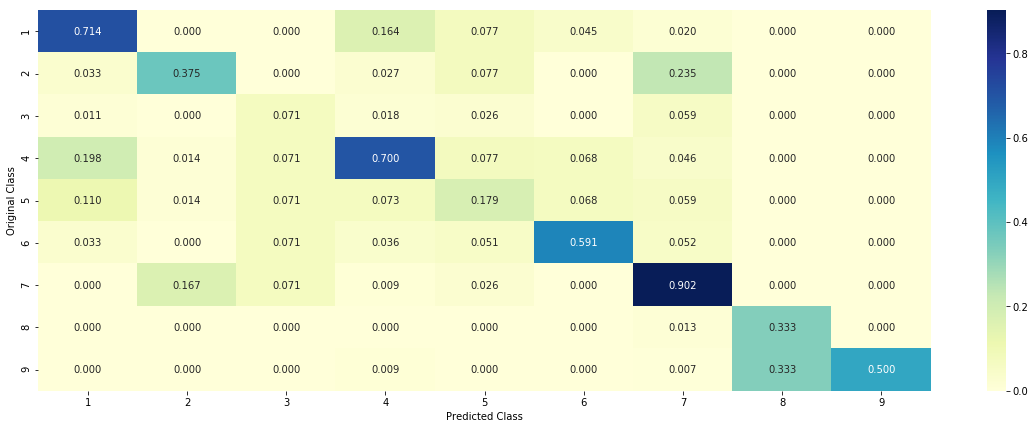

In [74]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.
#------------------------------------------------------------------------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Feature Importance, Correctly Classified Point

In [75]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[5.60e-03 1.10e-02 0.00e+00 2.25e-02 1.00e-03 2.00e-04 9.54e-01 4.60e-03
  1.00e-03]]
Actual Class : 7
--------------------------------------------------
94 Text feature [3t3] present in test data point [True]
119 Text feature [constitutively] present in test data point [True]
128 Text feature [oncogenes] present in test data point [True]
136 Text feature [receptors] present in test data point [True]
145 Text feature [oncogene] present in test data point [True]
154 Text feature [grew] present in test data point [True]
168 Text feature [activated] present in test data point [True]
170 Text feature [nude] present in test data point [True]
176 Text feature [extracellular] present in test data point [True]
199 Text feature [mitogen] present in test data point [True]
211 Text feature [6244] present in test data point [True]
241 Text feature [receptor] present in test data point [True]
256 Text feature [oncoproteins] present in test data po

#### Feature Importance, Incorrectly Classified Point

In [76]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.3413 0.0766 0.0071 0.383  0.0258 0.0167 0.1343 0.008  0.0073]]
Actual Class : 1
--------------------------------------------------
176 Text feature [g245d] present in test data point [True]
238 Text feature [degrade] present in test data point [True]
263 Text feature [suppressor] present in test data point [True]
Out of the top  500  features  3 are present in query point


### Linear SVM

#### HyperParameter Tuning

for C = 1e-05
Log Loss : 1.742180149873371
for C = 0.0001
Log Loss : 1.7266874353675254
for C = 0.001
Log Loss : 1.73534642979558
for C = 0.01
Log Loss : 1.7703781644034842
for C = 0.1
Log Loss : 2.123196954635861
for C = 1
Log Loss : 2.1174593633347274
for C = 10
Log Loss : 2.1417887961534956
for C = 100
Log Loss : 2.122430664011857


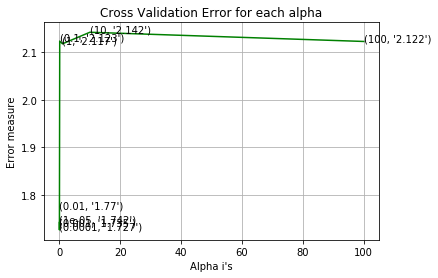

For values of best alpha =  0.0001 The train log loss is: 0.8291377467571395
For values of best alpha =  0.0001 The cross validation log loss is: 1.7266874353675254
For values of best alpha =  0.0001 The test log loss is: 1.747683950247911


In [54]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# -----------------------------------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#----------------------------------------------------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_word2vec, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_word2vec, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_word2vec)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_word2vec, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_word2vec, y_train)

predict_y = sig_clf.predict_proba(train_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_word2vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Testing Model with best HyperParameter

Log loss : 1.2701179566758858
Number of mis-classified points : 0.37781954887218044
-------------------------------------------------- Confusion Matrix --------------------------------------------------


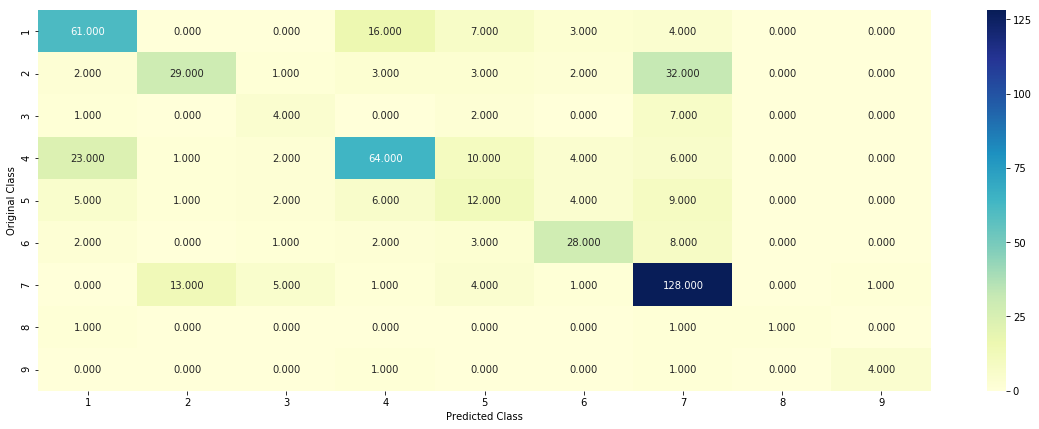

--------------------------------------------- Recall Matrix (Row Sum=1) ---------------------------------------------


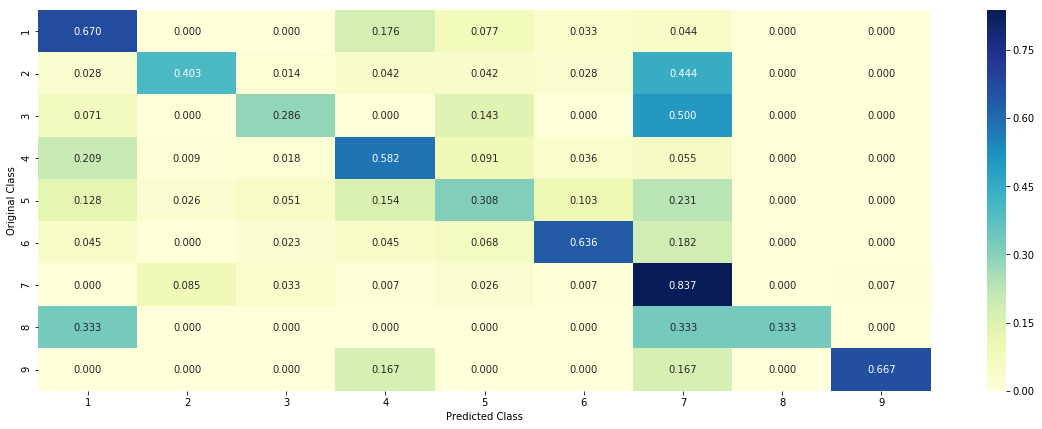

--------------------------------------------- Precision Matrix (Column Sum=1) ---------------------------------------------


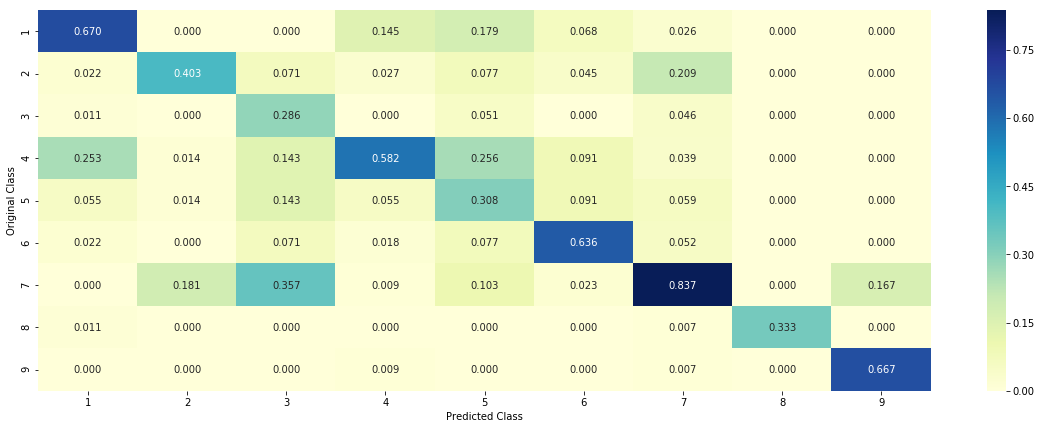

In [78]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.

# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### Feature Importance, Correctly Classified Point

In [79]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
#test_point_index = 1
test_point_index = 160
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1276 0.0943 0.007  0.0581 0.0294 0.0124 0.6559 0.0087 0.0066]]
Actual Class : 7
--------------------------------------------------
35 Text feature [constitutive] present in test data point [True]
38 Text feature [transforming] present in test data point [True]
53 Text feature [oncogenes] present in test data point [True]
56 Text feature [oncogene] present in test data point [True]
61 Text feature [transform] present in test data point [True]
78 Text feature [expressing] present in test data point [True]
99 Text feature [activating] present in test data point [True]
182 Text feature [qiacube] present in test data point [True]
206 Text feature [independently] present in test data point [True]
210 Text feature [phospho] present in test data point [True]
240 Text feature [activation] present in test data point [True]
242 Text feature [blot] present in test data point [True]
276 Text feature [tumoral] present in test data point [True]
2

#### Incorrectly classified point

In [80]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2967 0.0813 0.0145 0.3163 0.0466 0.0292 0.1983 0.0088 0.0083]]
Actual Class : 1
--------------------------------------------------
28 Text feature [degrade] present in test data point [True]
49 Text feature [suppressor] present in test data point [True]
73 Text feature [proteasome] present in test data point [True]
187 Text feature [g245d] present in test data point [True]
400 Text feature [precipitation] present in test data point [True]
Out of the top  500  features  5 are present in query point


### Random Forest Classifier

#### HyperParameter Tuning (One hot encoding)

In [81]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#--------------------------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.279598046660018
for n_estimators = 100 and max depth =  10
Log Loss : 1.1982792207831254
for n_estimators = 200 and max depth =  5
Log Loss : 1.2691366663284438
for n_estimators = 200 and max depth =  10
Log Loss : 1.1868662249344852
for n_estimators = 500 and max depth =  5
Log Loss : 1.2507773769914505
for n_estimators = 500 and max depth =  10
Log Loss : 1.1831295483752702
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2500167626049203
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1817064801604693
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2463106163759061
for n_estimators = 2000 and max depth =  10
Log Loss : 1.18016275758831
For values of best estimator =  2000 The train log loss is: 0.6968144233380015
For values of best estimator =  2000 The cross validation log loss is: 1.1801627353466082
For values of best estimator =  2000 The test log loss is: 1.128798412063425


#### Testing the Model with best HyperParameter(Onehot encoding)

Log loss : 1.1801627146749272
Number of mis-classified points : 0.37593984962406013
-------------------------------------------------- Confusion Matrix --------------------------------------------------


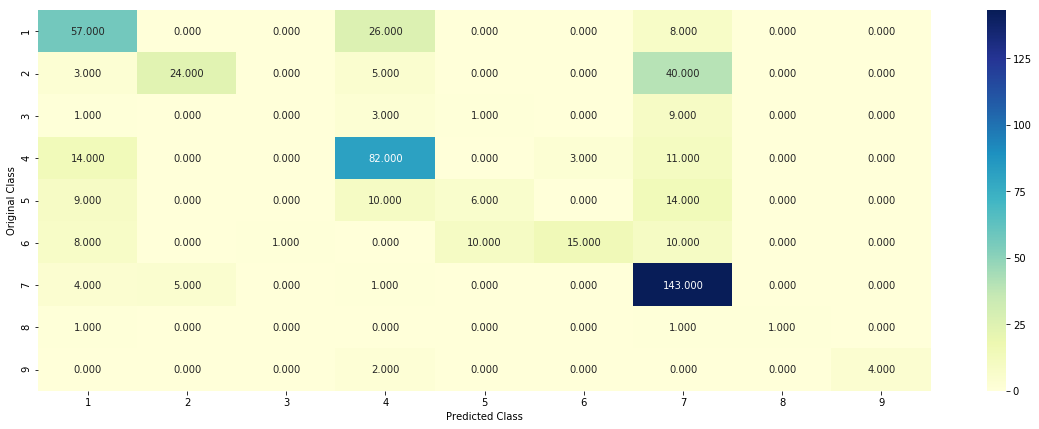

--------------------------------------------- Recall Matrix (Row Sum=1) ---------------------------------------------


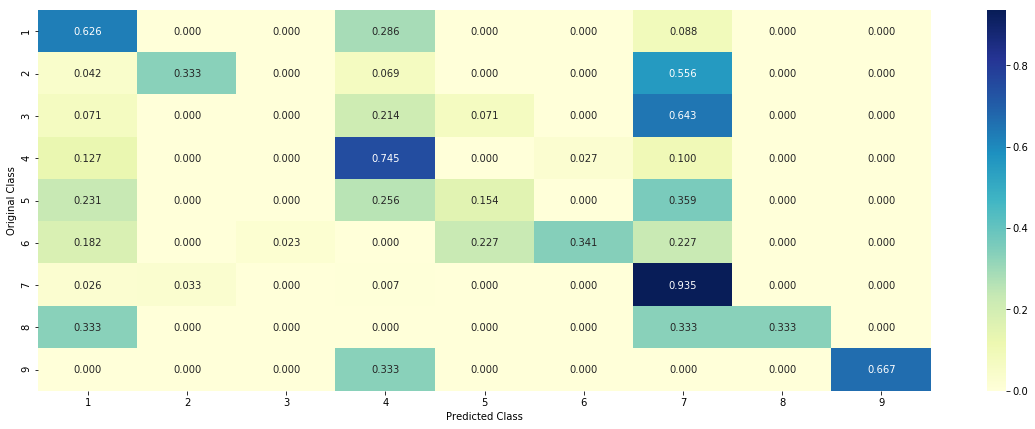

--------------------------------------------- Precision Matrix (Column Sum=1) ---------------------------------------------


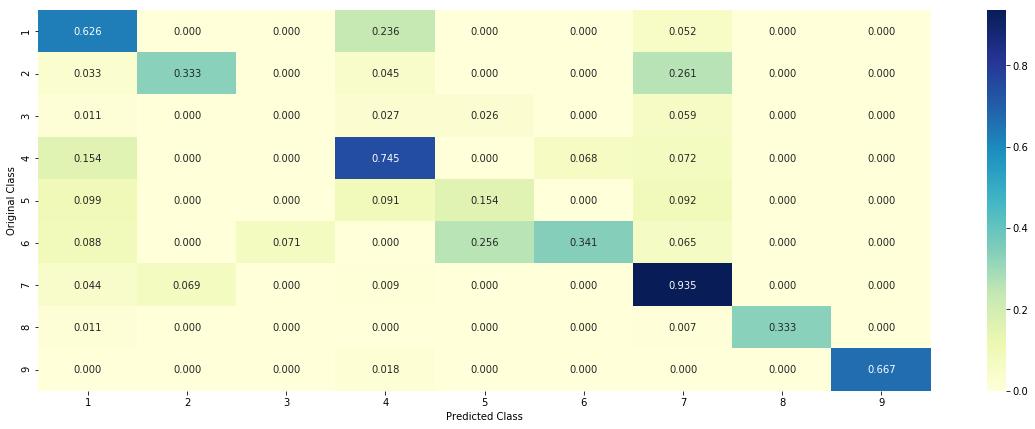

In [82]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### Feature Importance, Correctly classified Point

In [83]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0702 0.079  0.015  0.0664 0.0398 0.0327 0.6847 0.0056 0.0064]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [phosphorylation] present in test data point [True]
4 Text feature [activated] present in test data point [True]
5 Text feature [activation] present in test data point [True]
7 Text feature [inhibitors] present in test data point [True]
10 Text feature [constitutively] present in test data point [True]
11 Text feature [function] present in test data point [True]
14 Text feature [treatment] present in test data point [True]
15 Text feature [oncogenic] present in test data point [True]
16 Text feature [inhibitor] present in test data point [True]
18 Text feature [functional] present in test data point [True]
20 Text feature [signaling] present in test data point [True]
23 

#### Incorrectly Classified Point

In [88]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['Text'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2689 0.0892 0.0214 0.3129 0.0591 0.0504 0.1778 0.0089 0.0114]]
Actuall Class : 1
--------------------------------------------------
7 Text feature [inhibitors] present in test data point [True]
9 Text feature [suppressor] present in test data point [True]
11 Text feature [function] present in test data point [True]
14 Text feature [treatment] present in test data point [True]
15 Text feature [oncogenic] present in test data point [True]
16 Text feature [inhibitor] present in test data point [True]
18 Text feature [functional] present in test data point [True]
23 Text feature [growth] present in test data point [True]
25 Text feature [transforming] present in test data point [True]
28 Text feature [loss] present in test data point [True]
29 Text feature [stability] present in test data point [True]
35 Text feature [inhibition] present in test data point [True]
36 Text feature [cells] present in test data point [True]
42 Text feature

#### HyperParameter Tuning (With Response Coding)

In [89]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature)

# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------------------------------------------
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0572480379615197
for n_estimators = 10 and max depth =  3
Log Loss : 1.5960722475521787
for n_estimators = 10 and max depth =  5
Log Loss : 1.3659413575999246
for n_estimators = 10 and max depth =  10
Log Loss : 1.7419317076051317
for n_estimators = 50 and max depth =  2
Log Loss : 1.6490572676214077
for n_estimators = 50 and max depth =  3
Log Loss : 1.4496849694880884
for n_estimators = 50 and max depth =  5
Log Loss : 1.376093475386275
for n_estimators = 50 and max depth =  10
Log Loss : 1.6340759859330964
for n_estimators = 100 and max depth =  2
Log Loss : 1.5468975159771905
for n_estimators = 100 and max depth =  3
Log Loss : 1.4968610612575257
for n_estimators = 100 and max depth =  5
Log Loss : 1.34427408776612
for n_estimators = 100 and max depth =  10
Log Loss : 1.619854005560339
for n_estimators = 200 and max depth =  2
Log Loss : 1.6240736473052952
for n_estimators = 200 and max depth =  3
Log Loss : 1.5572402852779204
f

#### Testing the Model with best Hyperparameter 

Log loss : 1.34427408776612
Number of mis-classified points : 0.4774436090225564
-------------------------------------------------- Confusion Matrix --------------------------------------------------


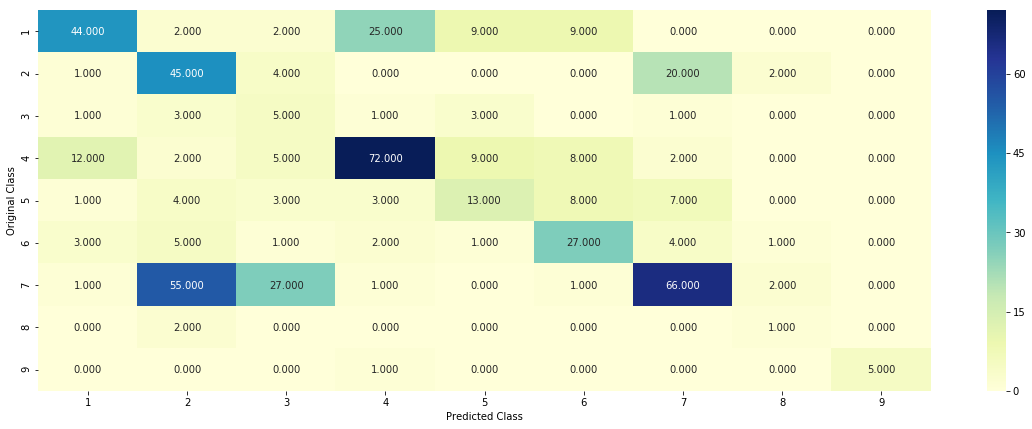

--------------------------------------------- Recall Matrix (Row Sum=1) ---------------------------------------------


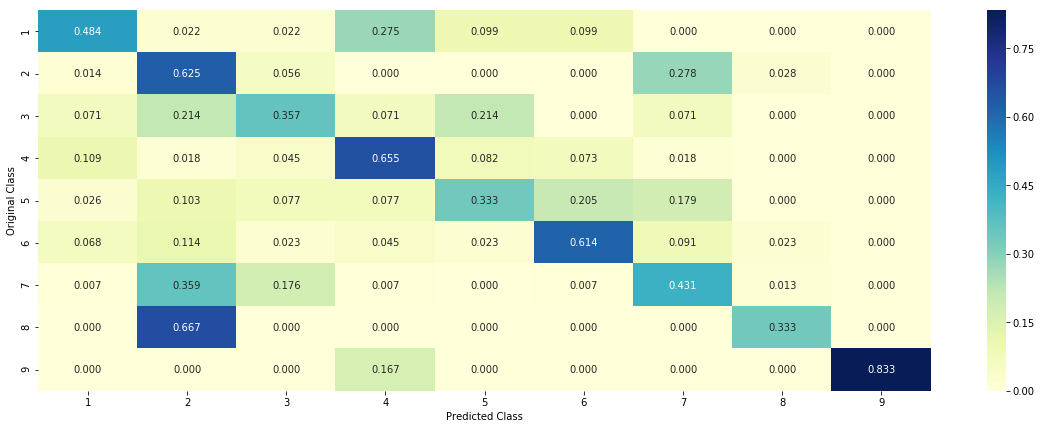

--------------------------------------------- Precision Matrix (Column Sum=1) ---------------------------------------------


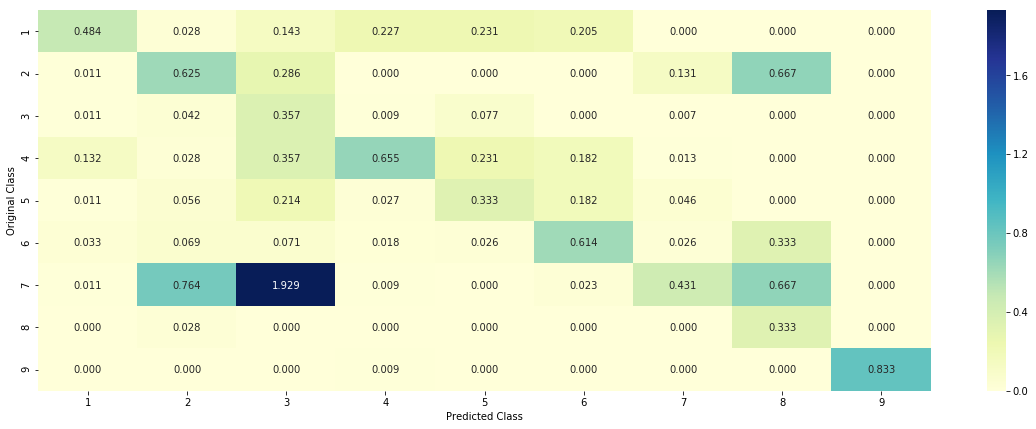

In [90]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# -------------------------------------------------------------------------------------------

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

#### Feature Importance, Correctly Classified Points

In [91]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 23
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 3
Predicted Class Probabilities: [[0.0157 0.0754 0.5267 0.0211 0.0319 0.0289 0.253  0.028  0.0191]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature


#### Incorrectly classified Points

In [92]:
test_point_index = 150
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0155 0.4935 0.0713 0.0248 0.041  0.0333 0.2806 0.0248 0.0151]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature


### Stack the Model

#### HyperParameter Tuning

In [69]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#------------------------------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# -------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# ----------------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(X_train, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(X_train, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(X_train, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(X_train, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv, sig_clf1.predict_proba(X_cv))))
sig_clf2.fit(X_train, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf2.predict_proba(X_cv))))
sig_clf3.fit(X_train, y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf3.predict_proba(X_cv))))
print("-" * 50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(X_train, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(X_cv))))
    log_error =log_loss(y_cv, sclf.predict_proba(X_cv))
    if best_alpha > log_error:
        best_alpha = log_error

ValueError: Input X must be non-negative

#### Testing Model with best HyperParameter

Log loss (train) on the stacking classifier : 0.6557443076435353
Log loss (CV) on the stacking classifier : 1.183672382218289
Log loss (test) on the stacking classifier : 1.1596560728194145
Number of missclassified point : 0.3593984962406015
-------------------------------------------------- Confusion Matrix --------------------------------------------------


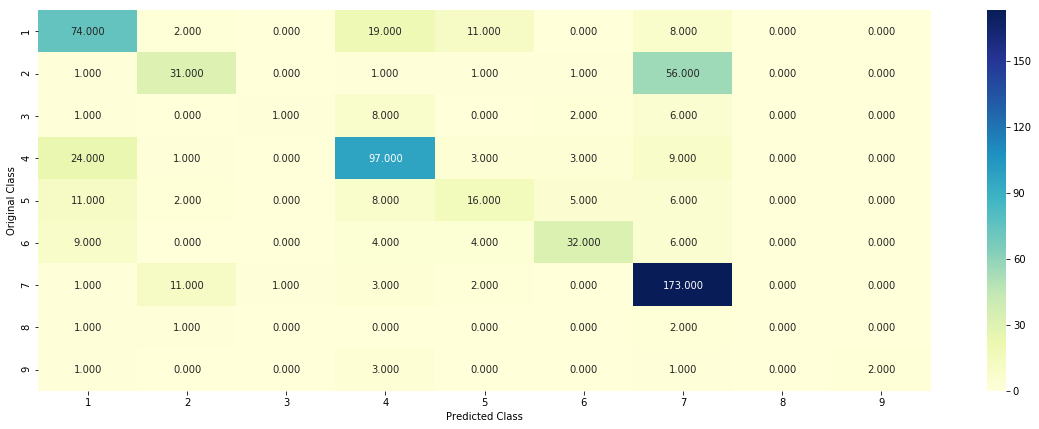

--------------------------------------------- Recall Matrix (Row Sum=1) ---------------------------------------------


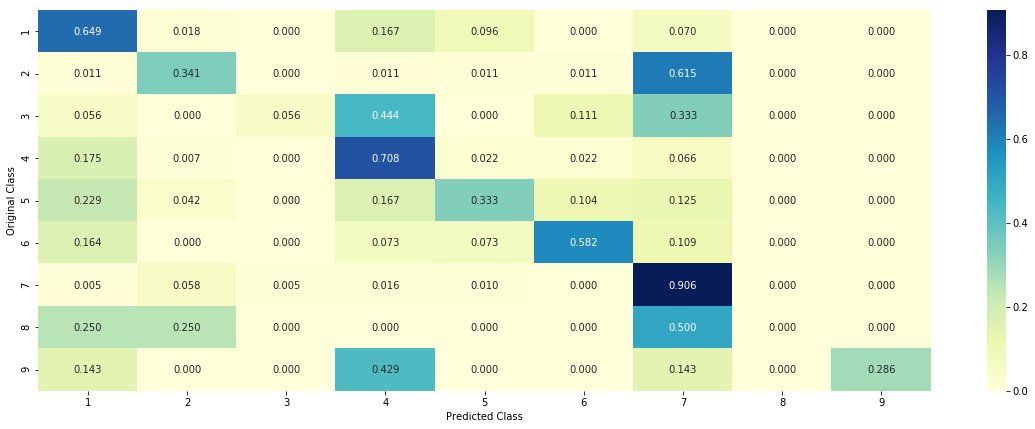

--------------------------------------------- Precision Matrix (Column Sum=1) ---------------------------------------------


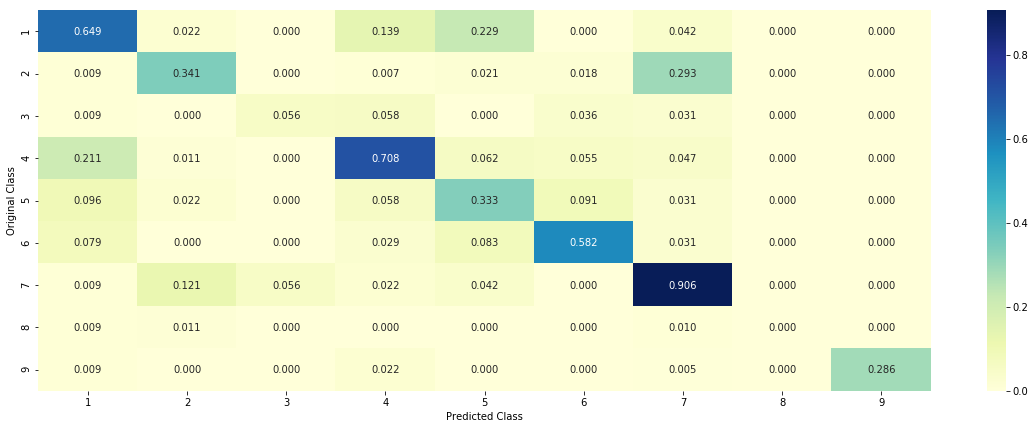

In [94]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

### Maximun Voting Classifier

In [55]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_word2vec, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_word2vec)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_word2vec)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_word2vec)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_word2vec)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_word2vec))

NameError: name 'sig_clf1' is not defined

### XG Boost Classifier

In [45]:
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=5, objective='multi:softprob', learning_rate=0.05)
clf.fit(train_x_word2vec, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_word2vec, y_train)

predict_y = sig_clf.predict_proba(cv_x_word2vec)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_word2vec)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

The cross validation log loss is: 1.808114272004806
The test log loss is: 1.8279586218309483
